## Imports


In [1]:
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
from tensorflow import keras
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.optimizers import Adam, Ftrl, Adamax, SGD, Adadelta, Nadam, Optimizer, RMSprop, Adagrad
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, TensorBoard, LambdaCallback
from tensorflow.keras import backend as K
from tensorflow.keras.activations import relu, sigmoid, softmax, tanh, hard_sigmoid, softsign, softplus, linear

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Reshape, MaxPooling2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters


In [3]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_histogram, plot_objective_2D
from skopt.utils import use_named_args
import sklearn.model_selection as sk
from sklearn.metrics import roc_auc_score


## What versions?


In [4]:
print("\nTensorFlow version is ", tf.__version__)
print("\nKeras version is ", tf.keras.__version__)
print("\nSciKit-optimize version is",  skopt.__version__)



TensorFlow version is  2.0.0

Keras version is  2.2.4-tf

SciKit-optimize version is 0.9.0


## Import the data for twitter sentiment


In [5]:
import pandas as pd

file = '/Volumes/Elements/GitHub/twitter-project/Data Files/twitter_sentiment_learn.csv'

learning_df = pd.read_csv(file)
print(learning_df.shape)
print(learning_df.head())


(385042, 6)
   Unnamed: 0          TWID       NEG       NEU       POS  \
0           0  7.680000e+17  0.049398  0.861395  0.089207   
1           1  7.680000e+17  0.006598  0.046810  0.946591   
2           2  7.680000e+17  0.032333  0.850945  0.116722   
3           3  7.680000e+17  0.008090  0.042331  0.949579   
4           4  7.680000e+17  0.009325  0.940488  0.050187   

                                                text  
0  #Incredible #India #Atulya #Bharat - Land of S...  
1  RT @KendallHuntRPD: The #firstdayofschool for ...  
2  RT @abbiesf_: Kate wrights figure is all I wan...  
3  Josh Jenkins is looking forward to TAB Breeder...  
4  Robert Pattinson Gets Ready to Hop on a Plane ...  


## Set up test and train


In [6]:
x = learning_df['text'].to_list()


##learning_df[["bad", "meh", "good"]] = 0
# for i in range(learning_df.shape[0]):
# if (learning_df.loc[i,"NEG"] >= learning_df.loc[i,"NEU"]) and (learning_df.loc[i,"NEG"] >= learning_df.loc[i,"POS"]):
##        learning_df.loc[i,"bad"] = 1
# elif (learning_df.loc[i,"NEU"] >= learning_df.loc[i,"NEG"]) and (learning_df.loc[i,"NEU"] >= learning_df.loc[i,"POS"]):
##        learning_df.loc[i,"meh"] = 1
# else:
##        learning_df.loc[i,"good"] = 1

##y = learning_df[["bad", "meh", "good"]]

y = learning_df[["NEG", "NEU", "POS"]]

##y = tarmac

x_train, x_test, y_train, y_test = sk.train_test_split(
    x, y, test_size=0.33, random_state=42)

# Convert to numpy arrays.
y_train = np.array(y_train)
y_test = np.array(y_test)
# print(x[1])

print("Train-set size: ", len(x_train))
print("Test-set size:  ", len(x_test))

data_text = x_train + x_test


Train-set size:  257978
Test-set size:   127064


## Tokenization and other fun stuff for the test/train/validation


In [7]:
# can be played with

num_words = 30000

tokenizer = Tokenizer(num_words=num_words)

# %%time
tokenizer.fit_on_texts(data_text)

x_train_tokens = tokenizer.texts_to_sequences(x_train)

x_test_tokens = tokenizer.texts_to_sequences(x_test)


In [8]:
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = math.floor(max_tokens)


## More work on the tokens and the training and testing sets


In [9]:
pad = 'pre'
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens,
                            padding=pad, truncating=pad)

x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)


## Set up hyperparameters


In [10]:
dim_learning_rate = Categorical(categories=[1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6],
                                name='learning_rate')

dim_num_dense_layers = Categorical(
    categories=[1, 2, 3, 4, 5, 6], name='num_dense_layers')

dim_num_dense_nodes = Categorical(
    categories=[10, 12, 15, 19, 24, 30], name='num_dense_nodes')


dim_activation_1 = Categorical(categories=['relu', 'sigmoid', 'softmax', 'tanh', 'hard_sigmoid',
                                           'softsign', 'softplus', 'linear'],
                               name='activation_1')
dim_activation_2 = Categorical(categories=['relu', 'sigmoid', 'softmax', 'tanh', 'hard_sigmoid',
                                           'softsign', 'softplus', 'linear'],
                               name='activation_2')

dim_recurrent_1 = Categorical(categories=['relu', 'sigmoid', 'softmax', 'tanh', 'hard_sigmoid',
                                          'softsign', 'softplus', 'linear'],
                              name='recurrent_activation_1')

dim_recurrent_2 = Categorical(categories=['relu', 'sigmoid', 'softmax', 'tanh', 'hard_sigmoid',
                                          'softsign', 'softplus', 'linear'],
                              name='recurrent_activation_2')

dim_batches_yo = size = Categorical(
    categories=[128, 160, 192, 256, 384, 512],  name='batchez_yo')


dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_dense_nodes,
              dim_activation_1,
              dim_activation_2,
              dim_recurrent_1,
              dim_recurrent_2,
              dim_batches_yo]


## Starting values


In [11]:
default_parameters = [1e-3, 3, 10, 'softplus',
                      'relu', 'sigmoid', 'softsign', 128]


## Now the optimizing function


In [12]:
figure_of_merit = 2 * max_tokens  # was 100
first_layer = math.floor(max_tokens/2) + 2
second_layer = math.floor(max_tokens/3) + 2
third_layer = math.floor(max_tokens/4) + 3
fourth_layer = math.floor(max_tokens/5) + 3
embedding_size = figure_of_merit


def log_dir_name(learning_rate,
                 num_dense_layers,
                 num_dense_nodes,
                 activation_1,
                 activation_2,
                 recurrent_activation_1,
                 recurrent_activation_2,
                 batchez_yo):
    # ,
 # optimizations_yo):

    # The dir-name for the TensorBoard log-dir.
    s = "./19_logs/lr_{0:.0e}_layers_{1}_nodes_{2}_{3}/"

    # Insert all the hyper-parameters in the dir-name.
    log_dir = s.format(learning_rate,
                       num_dense_layers,
                       num_dense_nodes,
                       activation_1,
                       activation_2,
                       recurrent_activation_1,
                       recurrent_activation_2,
                       batchez_yo)
    # ,
    # optimizations_yo)
    tf.autograph.experimental.do_not_convert(
        func=None)

    return log_dir


def create_model(learning_rate,
                 num_dense_layers,
                 num_dense_nodes,
                 activation_1,
                 activation_2,
                 recurrent_activation_1,
                 recurrent_activation_2,
                 batchez_yo):
    # ,
    # optimizations_yo):

    # Start construction of a Keras Sequential model.
    model = Sequential()

    # Add an input layer which is similar to a feed_dict in TensorFlow.
    # Note that the input-shape must be a tuple containing the image-size.
    model.add(Embedding(input_dim=num_words,
                        output_dim=embedding_size,
                        input_length=max_tokens,
                        name='layer_embedding'))


# model.add(Flatten())

    # Put in the GRU flavor
    model.add(GRU(units=first_layer, activation=activation_1,
                  recurrent_activation=recurrent_activation_1, return_sequences=True))

    i = 0
    j = num_dense_layers
    while i < j:
        model.add(GRU(units=math.floor(max_tokens/(i+2)) + 2, activation=activation_2,
                      recurrent_activation=recurrent_activation_2, return_sequences=True))
        i = i + 1

    model.add(GRU(units=fourth_layer, activation=activation_1,
                  recurrent_activation=recurrent_activation_1, return_sequences=False))
    # , return_sequences = False))

    model.add(Dense(3, activation=activation_2))  # was 3

    # Use the Adam method for training the network.
    # We want to find the best learning-rate for the Adam method.
    # if optimizations_yo == 1:
    ##    optimizer = Adadelta(lr=learning_rate)
    ##  print("Optimizer is Adadelta.")
   # elif optimizations_yo == 2:
   ##     optimizer = Adagrad(lr=learning_rate)
   ##     print("Optimizer is Adagrad.")
    # elif optimizations_yo == 3:
    ##    optimizer = Adam(lr=learning_rate)
    ##    print("Optimizer is Adam.")
    # elif optimizations_yo == 4:
    ##    optimizer = Adamax(lr=learning_rate)
    ##    print("Optimizer is Adamax.")
    # else:
    ##    optimizer = Nadam(lr=learning_rate)
    ##    print("Optimizer is Nadam.")

    # In Keras we need to compile the model so it can be trained.
    optimizering = Adam(learning_rate=learning_rate)

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizering,
                  metrics=['accuracy'])

    tf.autograph.experimental.do_not_convert(
        func=None)

    return model


## Now to make it more Gated and so on


## Train and evaluate the model


In [13]:
path_best_model = '19_best_model.h5'


best_accuracy = 0.0

##validation_data = (data.x_val, data.y_val)


@use_named_args(dimensions=dimensions)
def fitness(learning_rate,
            num_dense_layers,
            num_dense_nodes,
            activation_1,
            activation_2,
            recurrent_activation_1,
            recurrent_activation_2,
            batchez_yo):
    # ,
    # optimizations_yo):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """
    tf.autograph.experimental.do_not_convert(
        func=None)

    # Create the neural network with these hyper-parameters.
    model = create_model(learning_rate=learning_rate,
                         num_dense_layers=num_dense_layers,
                         num_dense_nodes=num_dense_nodes,
                         activation_1=activation_1,
                         activation_2=activation_2,
                         recurrent_activation_1=recurrent_activation_1,
                         recurrent_activation_2=recurrent_activation_2,
                         batchez_yo=batchez_yo)
    # ,
    # optimizations_yo = optimizations_yo)

    # Dir-name for the TensorBoard log-files.
    log_dir = log_dir_name(learning_rate,
                           num_dense_layers,
                           num_dense_nodes,
                           activation_1,
                           activation_2,
                           recurrent_activation_1,
                           recurrent_activation_2,
                           batchez_yo)
    # ,
    # optimizations_yo)

    # Create a callback-function for Keras which will be
    # run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    # Note that there are complications when histogram_freq=1.
    # It might give strange errors and it also does not properly
    # support Keras data-generators for the validation-set.
    callback_log = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        write_graph=True,
        write_grads=False,
        write_images=False)

    callbackx = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                 patience=0,
                                                 restore_best_weights=True)
 # Not used in this version

    class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if(logs.get('val_accuracy') > 0.95):
                print(
                    "\nReached 95% validation accuracy, so changing the optimizer to Nadam.")
                optimizer = Nadam(learning_rate=learning_rate/5)
                self.model.stop_training = False
            if(logs.get('val_accuracy') > 0.97):
                print(
                    "\nReached 97% validation accuracy, so changing the optimizer to Adadelta.")
                optimizer = Adadelta(learning_rate=learning_rate/10)
                self.model.stop_training = False

    call_it = myCallback()

    # Use Keras to train the model.
    history = model.fit(x=x_train_pad,
                        y=y_train,
                        epochs=8,
                        batch_size=batchez_yo,
                        validation_split=0.3,
                        callbacks=[callback_log, callbackx, call_it])

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-2]

    # Print the classification accuracy.
    print('+++++++++++++++++++++++++++')
    print('Accuracy: {0:.2%}'.format(accuracy))
    print('@@@@@@@@@@@@@@@@@@@@@')
    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('activation_1:', activation_1)
    print('activation_2:', activation_2)
    print('recurrent_activation_1:', recurrent_activation_1)
    print('recurrent_activation_2:', recurrent_activation_2)
    print('batches are ', batchez_yo)
    print('********************')
    print('The model summary is ', model.summary)

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        model.save(path_best_model)

        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model

    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()

    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.

    return -accuracy


## Is this the test?


In [14]:
% % time

search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI',  # Expected of improvement.
                            n_calls=11,
                            x0=default_parameters)


2022-06-18 13:33:13.314406: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-18 13:33:13.314824: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 16. Tune using inter_op_parallelism_threads for best performance.


Train on 180584 samples, validate on 77394 samples
Epoch 1/8
   128/180584 [..............................] - ETA: 4:23:03 - loss: 5.0330 - accuracy: 0.7266

2022-06-18 13:33:25.191284: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


180584/180584 [==============================] - 560s 3ms/sample - loss: nan - accuracy: 0.3261 - val_loss: nan - val_accuracy: 0.0581
Epoch 2/8
180584/180584 [==============================] - 496s 3ms/sample - loss: nan - accuracy: 0.0568 - val_loss: nan - val_accuracy: 0.0581
+++++++++++++++++++++++++++
Accuracy: 5.81%
@@@@@@@@@@@@@@@@@@@@@
learning rate: 1.0e-03
num_dense_layers: 3
num_dense_nodes: 10
activation_1: softplus
activation_2: relu
recurrent_activation_1: sigmoid
recurrent_activation_2: softsign
batches are  128
********************
The model summary is  <bound method Network.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f83e253acd0>>
Train on 180584 samples, validate on 77394 samples
Epoch 1/8
   256/180584 [..............................] - ETA: 1:45:40 - loss: 9.0719 - accuracy: 0.1328

2022-06-18 13:51:00.446913: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


180584/180584 [==============================] - 280s 2ms/sample - loss: nan - accuracy: 0.4446 - val_loss: nan - val_accuracy: 0.0581
Epoch 2/8
180584/180584 [==============================] - 275s 2ms/sample - loss: nan - accuracy: 0.0568 - val_loss: nan - val_accuracy: 0.0581
+++++++++++++++++++++++++++
Accuracy: 5.81%
@@@@@@@@@@@@@@@@@@@@@
learning rate: 1.0e-03
num_dense_layers: 3
num_dense_nodes: 19
activation_1: linear
activation_2: relu
recurrent_activation_1: linear
recurrent_activation_2: softsign
batches are  256
********************
The model summary is  <bound method Network.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f83b3b27cd0>>
Train on 180584 samples, validate on 77394 samples
Epoch 1/8
   256/180584 [..............................] - ETA: 3:04:38 - loss: 6.8343 - accuracy: 0.1680

2022-06-18 14:00:22.929162: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


180584/180584 [==============================] - 398s 2ms/sample - loss: 2.8987 - accuracy: 0.5910 - val_loss: 9.3563 - val_accuracy: 0.6099
Epoch 2/8
180584/180584 [==============================] - 426s 2ms/sample - loss: 8.6417 - accuracy: 0.6098 - val_loss: 9.2372 - val_accuracy: 0.6099
+++++++++++++++++++++++++++
Accuracy: 60.99%
@@@@@@@@@@@@@@@@@@@@@
learning rate: 5.0e-05
num_dense_layers: 6
num_dense_nodes: 12
activation_1: linear
activation_2: linear
recurrent_activation_1: sigmoid
recurrent_activation_2: softplus
batches are  256
********************
The model summary is  <bound method Network.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f5d61989ad0>>
Train on 180584 samples, validate on 77394 samples
Epoch 1/8
   384/180584 [..............................] - ETA: 57:56 - loss: 1.0653 - accuracy: 0.6198

2022-06-18 14:13:59.042673: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


180584/180584 [==============================] - 186s 1ms/sample - loss: 1.0498 - accuracy: 0.6089 - val_loss: 1.0305 - val_accuracy: 0.6099
Epoch 2/8
180584/180584 [==============================] - 192s 1ms/sample - loss: 0.9949 - accuracy: 0.6089 - val_loss: 0.9360 - val_accuracy: 0.6099
+++++++++++++++++++++++++++
Accuracy: 60.99%
@@@@@@@@@@@@@@@@@@@@@
learning rate: 5.0e-05
num_dense_layers: 1
num_dense_nodes: 19
activation_1: relu
activation_2: hard_sigmoid
recurrent_activation_1: softmax
recurrent_activation_2: softmax
batches are  384
********************
The model summary is  <bound method Network.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f58f31495d0>>
Train on 180584 samples, validate on 77394 samples
Epoch 1/8
   160/180584 [..............................] - ETA: 2:32:35 - loss: 1.3058 - accuracy: 0.0437

2022-06-18 14:20:18.539849: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


180584/180584 [==============================] - 406s 2ms/sample - loss: 1.2195 - accuracy: 0.0568 - val_loss: 1.1478 - val_accuracy: 0.0581
Epoch 2/8
180584/180584 [==============================] - 408s 2ms/sample - loss: 1.0895 - accuracy: 0.3977 - val_loss: 1.0354 - val_accuracy: 0.6099
Epoch 3/8
180584/180584 [==============================] - 440s 2ms/sample - loss: 0.9894 - accuracy: 0.6089 - val_loss: 0.9476 - val_accuracy: 0.6099
+++++++++++++++++++++++++++
Accuracy: 60.99%
@@@@@@@@@@@@@@@@@@@@@
learning rate: 1.0e-05
num_dense_layers: 2
num_dense_nodes: 19
activation_1: softplus
activation_2: softplus
recurrent_activation_1: softsign
recurrent_activation_2: softmax
batches are  160
********************
The model summary is  <bound method Network.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f591ac10d50>>
Train on 180584 samples, validate on 77394 samples
Epoch 1/8
   160/180584 [..............................] - ETA: 4:22:02 - loss: nan - accur

2022-06-18 14:41:20.800012: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


180584/180584 [==============================] - 539s 3ms/sample - loss: nan - accuracy: 0.0568 - val_loss: nan - val_accuracy: 0.0581
Epoch 2/8
180584/180584 [==============================] - 568s 3ms/sample - loss: nan - accuracy: 0.0568 - val_loss: nan - val_accuracy: 0.0581
+++++++++++++++++++++++++++
Accuracy: 5.81%
@@@@@@@@@@@@@@@@@@@@@
learning rate: 1.0e-03
num_dense_layers: 5
num_dense_nodes: 19
activation_1: tanh
activation_2: softplus
recurrent_activation_1: softsign
recurrent_activation_2: softplus
batches are  160
********************
The model summary is  <bound method Network.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f656e325e90>>
Train on 180584 samples, validate on 77394 samples
Epoch 1/8
   160/180584 [..............................] - ETA: 2:44:24 - loss: 1.0184 - accuracy: 0.3187

2022-06-18 14:59:43.860494: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


180584/180584 [==============================] - 403s 2ms/sample - loss: 0.9959 - accuracy: 0.3343 - val_loss: 0.9770 - val_accuracy: 0.3320
Epoch 2/8
180584/180584 [==============================] - 536s 3ms/sample - loss: 0.9585 - accuracy: 0.3343 - val_loss: 0.9434 - val_accuracy: 0.3320
+++++++++++++++++++++++++++
Accuracy: 33.20%
@@@@@@@@@@@@@@@@@@@@@
learning rate: 5.0e-06
num_dense_layers: 2
num_dense_nodes: 15
activation_1: sigmoid
activation_2: relu
recurrent_activation_1: sigmoid
recurrent_activation_2: softmax
batches are  160
********************
The model summary is  <bound method Network.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7ec657147d90>>
Train on 180584 samples, validate on 77394 samples
Epoch 1/8
   384/180584 [..............................] - ETA: 1:41:13 - loss: nan - accuracy: 0.0495

2022-06-18 15:15:28.784187: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


180584/180584 [==============================] - 259s 1ms/sample - loss: nan - accuracy: 0.0568 - val_loss: nan - val_accuracy: 0.0581
Epoch 2/8
180584/180584 [==============================] - 244s 1ms/sample - loss: nan - accuracy: 0.0568 - val_loss: nan - val_accuracy: 0.0581
+++++++++++++++++++++++++++
Accuracy: 5.81%
@@@@@@@@@@@@@@@@@@@@@
learning rate: 5.0e-04
num_dense_layers: 3
num_dense_nodes: 15
activation_1: softmax
activation_2: sigmoid
recurrent_activation_1: softplus
recurrent_activation_2: softplus
batches are  384
********************
The model summary is  <bound method Network.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f591cce5710>>
Train on 180584 samples, validate on 77394 samples
Epoch 1/8
   128/180584 [..............................] - ETA: 5:47:40 - loss: 1.1982 - accuracy: 0.0469

2022-06-18 15:23:54.323692: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


180584/180584 [==============================] - 609s 3ms/sample - loss: 1.1430 - accuracy: 0.3161 - val_loss: 1.0704 - val_accuracy: 0.3320
Epoch 2/8
180584/180584 [==============================] - 638s 4ms/sample - loss: 1.0174 - accuracy: 0.3343 - val_loss: 0.9666 - val_accuracy: 0.3320
+++++++++++++++++++++++++++
Accuracy: 33.20%
@@@@@@@@@@@@@@@@@@@@@
learning rate: 1.0e-05
num_dense_layers: 4
num_dense_nodes: 10
activation_1: softsign
activation_2: softplus
recurrent_activation_1: linear
recurrent_activation_2: hard_sigmoid
batches are  128
********************
The model summary is  <bound method Network.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7e48cf537fd0>>
Train on 180584 samples, validate on 77394 samples
Epoch 1/8
   256/180584 [..............................] - ETA: 2:00:27 - loss: 5.1655 - accuracy: 0.1602

2022-06-18 15:44:37.511164: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


180584/180584 [==============================] - 239s 1ms/sample - loss: 1.8504 - accuracy: 0.0571 - val_loss: 1.8820 - val_accuracy: 0.0581
Epoch 2/8
180584/180584 [==============================] - 220s 1ms/sample - loss: 1.8504 - accuracy: 0.0568 - val_loss: 1.8820 - val_accuracy: 0.0581
+++++++++++++++++++++++++++
Accuracy: 5.81%
@@@@@@@@@@@@@@@@@@@@@
learning rate: 5.0e-04
num_dense_layers: 1
num_dense_nodes: 10
activation_1: tanh
activation_2: linear
recurrent_activation_1: softplus
recurrent_activation_2: hard_sigmoid
batches are  256
********************
The model summary is  <bound method Network.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7e22a8dd8e10>>
Train on 180584 samples, validate on 77394 samples
Epoch 1/8
   512/180584 [..............................] - ETA: 1:33:57 - loss: 1.0114 - accuracy: 0.3555

2022-06-18 15:52:23.266655: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


180584/180584 [==============================] - 241s 1ms/sample - loss: 0.8898 - accuracy: 0.5763 - val_loss: 0.8735 - val_accuracy: 0.6099
Epoch 2/8
180584/180584 [==============================] - 260s 1ms/sample - loss: 0.8722 - accuracy: 0.6089 - val_loss: 0.8734 - val_accuracy: 0.6099
+++++++++++++++++++++++++++
Accuracy: 60.99%
@@@@@@@@@@@@@@@@@@@@@
learning rate: 1.0e-03
num_dense_layers: 5
num_dense_nodes: 12
activation_1: relu
activation_2: hard_sigmoid
recurrent_activation_1: sigmoid
recurrent_activation_2: relu
batches are  512
********************
The model summary is  <bound method Network.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7e43028f6350>>
CPU times: user 7h 38min 31s, sys: 20h 4min 42s, total: 1d 3h 43min 13s
Wall time: 2h 27min 15s


In [15]:
import datetime

time_now = datetime.datetime.now()


print("the date and time is ", time_now)


the date and time is  2022-06-18 16:00:29.163446


## Evaluate the model


AttributeError: 'str' object has no attribute 'decode'

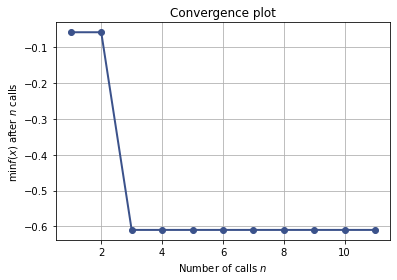

In [16]:
plot_convergence(search_result)

search_result.x

model = load_model(path_best_model)

result = model.evaluate(x=x_test_pad,
                        y=y_test)

for name, value in zip(model.metrics_names, result):
    print(name, value)

print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]))


In [ ]:
% % time
default_parameters_1 = [1e-6, 6, 30, 'linear',
                        'linear', 'linear', 'linear', 512]

search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='LCB',  # Lower Confidence Bound.
                            n_calls=12,
                            x0=default_parameters_1)


In [ ]:


time_now = datetime.datetime.now()


print("the date and time is ", time_now)


In [ ]:
plot_convergence(search_result)

search_result.x

model = load_model(path_best_model)

result = model.evaluate(x=x_test_pad,
                        y=y_test)

for name, value in zip(model.metrics_names, result):
    print(name, value)

print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]))


In [ ]:
% % time
default_parameters_2 = [1e-5, 3, 10, 'sigmoid', 'sigmoid', 'relu', 'relu', 256]

search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='gp_hedge',  # Probability of improvement.
                            n_calls=12,
                            x0=default_parameters_2)


In [ ]:

time_now = datetime.datetime.now()


print("the date and time is ", time_now)


In [ ]:
plot_convergence(search_result)

search_result.x

model = load_model(path_best_model)

result = model.evaluate(x=x_test_pad,
                        y=y_test)

for name, value in zip(model.metrics_names, result):
    print(name, value)

print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]))


In [ ]:
% % time
default_parameters_3 = [1e-5, 3, 10, 'softmax',
                        'sigmoid', 'relu', 'softmax', 384]

search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='gp_hedge',  # Hedge of the above 3.
                            n_calls=10\2,
                            x0=default_parameters_3)


In [ ]:

time_now = datetime.datetime.now()


print("the date and time is ", time_now)


In [ ]:
plot_convergence(search_result)

search_result.x

model = load_model(path_best_model)

result = model.evaluate(x=x_test_pad,
                        y=y_test)

for name, value in zip(model.metrics_names, result):
    print(name, value)

print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]))
